# Route Analysis
This notebook loads the complete NARN database and is used to analyze the data that is in it.

In [3]:
import geopandas as gpd
import networkx as nx
# import osmnx as ox
from shapely import geometry, ops
import numpy as np
import matplotlib.pyplot as plt
import requests

First step is to load the data. The geojson file is not part of the git repo since it is too large. It can be downloaded and palced in thsi directory as indicated in the README file. This will take a few minutes to load and may throw an error the first time. This error can be ignored (I think).

In [4]:
data = gpd.read_file('North_American_Rail_Network_Lines.geojson')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Data exploration
Now that we have the data, let's get some information abtou what is in the "database". The first thing we can look at is the coordinate system that is used.

In [5]:
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

EPSG:4326 is a lat/long coordinate system. We will want to convert this to meters. One of the msot common coordinate systems is EPSE:3857. This is used by Google Maps and Open Stree Maps.

In [6]:
data = data.to_crs(3857)

In [7]:
data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can also see what fields are available.

In [8]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 302988 entries, 0 to 302987
Data columns (total 35 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   OBJECTID       302988 non-null  int64   
 1   FRAARCID       302988 non-null  int64   
 2   FRFRANODE      302988 non-null  int64   
 3   TOFRANODE      302988 non-null  int64   
 4   STFIPS         235945 non-null  object  
 5   CNTYFIPS       235945 non-null  object  
 6   STCNTYFIPS     235945 non-null  object  
 7   STATEAB        302988 non-null  object  
 8   COUNTRY        302988 non-null  object  
 9   FRADISTRCT     302988 non-null  int64   
 10  RROWNER1       299857 non-null  object  
 11  RROWNER2       3006 non-null    object  
 12  RROWNER3       27 non-null      object  
 13  TRKRGHTS1      51734 non-null   object  
 14  TRKRGHTS2      13823 non-null   object  
 15  TRKRGHTS3      3252 non-null    object  
 16  TRKRGHTS4      919 non-null     object  
 17  TR

How many records are in the database?

In [9]:
len(data)

302988

We can reduce this significantly by only looking at mainline tracks.

In [10]:
m_data = data[data['NET']=='M']
len(m_data)

97100

Out of curiosity, we see how many of the segments are sidings.

In [11]:
s_data = data[data['NET']=='S']
len(s_data)

10236

## Railroads
In this section we will explore how much track each railroad has access to. Let's first create a dictionary with the 7 railroads.

In [12]:
railroads = [
    {'code': 'BNSF', 'name': 'Burlington Northern and Santa Fe'},
    {'code': 'CN', 'name': 'Canadian National Railway'},
    {'code': 'CP', 'name': 'Canadian Pacific Railway'},
    {'code': 'CSXT', 'name': 'CSX Transportation'},
    {'code': 'NS', 'name': 'Norfolk Southern Railway'},
    {'code': 'KCS', 'name': 'Kansas City Southern Railway'},
    {'code': 'UP', 'name': 'Union Pacific'}
]

There are a lot of different railroads included in the database, but we only care about the 7 above.

In [13]:
len(m_data['RROWNER1'].drop_duplicates())

718

How many yards are available across North America?

In [25]:
yards = m_data['YARDNAME'].drop_duplicates().sort_values()
len(yards)

1232

### Burlington Northern and Sante Fe
Take a look at BNSF

In [21]:
rr = railroads[0]['code']
rr

'BNSF'

In [22]:
bnsf_data = m_data[m_data[['RROWNER1', 'RROWNER2', 'RROWNER3', 'TRKRGHTS1', 'TRKRGHTS2', 'TRKRGHTS3', 'TRKRGHTS4', 'TRKRGHTS5', 'TRKRGHTS6', 'TRKRGHTS7', 'TRKRGHTS8', 'TRKRGHTS9']].isin([rr]).any(axis=1)]

The number of track segments BNSF has rights to in the database.

In [23]:
len(bnsf_data)

18234

The number of yards BNSF owns.

In [28]:
bnsf = m_data[m_data['RROWNER1']==rr]
bnsf_yards = bnsf['YARDNAME'].drop_duplicates().sort_values()
len(bnsf_yards)

171

### Norfolk Southern
Take a look at Norfolk Southern tracks.

In [29]:
rr = railroads[4]['code']
rr

'NS'

In [30]:
ns_data = m_data[m_data[['RROWNER1', 'RROWNER2', 'RROWNER3', 'TRKRGHTS1', 'TRKRGHTS2', 'TRKRGHTS3', 'TRKRGHTS4', 'TRKRGHTS5', 'TRKRGHTS6', 'TRKRGHTS7', 'TRKRGHTS8', 'TRKRGHTS9']].isin([rr]).any(axis=1)]

The number of track segments NS has rights to in the database.

In [31]:
len(ns_data)

14114

The number of yards NS owns.

In [33]:
ns = m_data[m_data['RROWNER1']==rr]
ns_yards = ns['YARDNAME'].drop_duplicates().sort_values()
len(ns_yards)

187

Lets look at one yard, Enola near Harrisburg.

In [36]:
enola = ns_data[ns_data['YARDNAME']=='ENOLA']

Since we are working in GeoPandas, we can simply plot out the track geometry.

<Axes: >

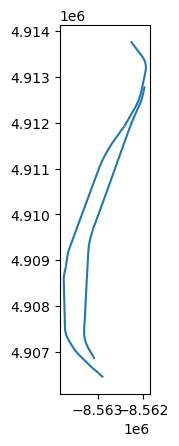

In [37]:
enola.plot()

In [38]:
ns_yards.to_string()

'192589                     55TH ST\n54690                    A O SMITH\n152941                      ALBANY\n96143                      ALTOONA\n91055                     ANDOVOER\n178740                     ANDREWS\n191722                 ASHLAND AVE\n101315            ASHTABULA HARBOR\n176263                AUGUSTA (NS)\n103859                     AUVILLE\n82210                        BAKER\n81853                 BAKER STREET\n98419                       BANNON\n97916                     BELLEVUE\n79857                BEVIER STREET\n82410                   BINGHAMTON\n82162                        BISON\n121233                       BLAIR\n102483                   BLUEFIELD\n90925                      BRISTOL\n104257                    BROADWAY\n59575                     BROOKLYN\n153834                     BROSNAN\n154172              BRUNSWICK (NS)\n98400                      BUCKEYE\n80039                  BUFFALO S K\n193612                BURNS HARBOR\n187039           BURNSIDE T

## All yards
Lets take a look at all of the yards that are in the database. On inspection of the data above, there is the Enola yard for Harrisbrug that is owned by Norfolk Southern. There is also and Intermodal yard in Harrisburg that is on the east side of the river. It is not listed as a "NS" route. 

In [42]:
m_yards = m_data['YARDNAME'].drop_duplicates().sort_values()

In [43]:
len(m_yards)

1232

In [52]:
# m_yards.to_string()

There is no Harrisburg Intermodal on any mainline tracks. We can try once more on the whole dataset and see if it comes up there.

In [45]:
yards = data['YARDNAME'].drop_duplicates().sort_values()

In [46]:
len(yards)

2315

In [51]:
# yards.to_string()

There is a Harrisburg yard in this list.

In [49]:
h_burg_yard = data[data['YARDNAME']=='HARRISBURG YARD']

In [53]:
h_burg_yard['RROWNER1']

95295     NS
95544     NS
95546     NS
115694    NS
115695    NS
          ..
289403    NS
289404    NS
289405    NS
289406    NS
289407    NS
Name: RROWNER1, Length: 162, dtype: object

<Axes: >

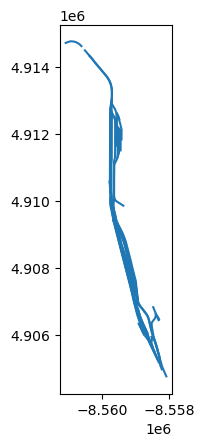

In [54]:
h_burg_yard.plot()

## Route Analysis
Once we map yards to FRANODEIDs we can then use networkx to find the best route from one yar dto the next. The plan should be instead to take the NARN database, simplify it a bit, then add altitude, gradient, and curvature information.

We will need to modify the current database in SCORE to handle some of the additional field we want.

We can look at the secpodn record in the mainline data and see that the mainline data includes more than the 7 class 1 railroads. So the next step is to filter this down to the 7 class 1s.

In [55]:
m_data.iloc[1]

OBJECTID                                                         3
FRAARCID                                                    300002
FRFRANODE                                                   330112
TOFRANODE                                                   330117
STFIPS                                                          16
CNTYFIPS                                                       031
STCNTYFIPS                                                   16031
STATEAB                                                         ID
COUNTRY                                                         US
FRADISTRCT                                                       8
RROWNER1                                                      EIRR
RROWNER2                                                       NaN
RROWNER3                                                       NaN
TRKRGHTS1                                                      NaN
TRKRGHTS2                                                     

Lets create a list of the majors.

In [61]:
rrs = [r['code'] for r in railroads]
rrs

['BNSF', 'CN', 'CP', 'CSXT', 'NS', 'KCS', 'UP']

In [62]:
mc1_data = m_data[m_data[['RROWNER1', 'RROWNER2', 'RROWNER3', 'TRKRGHTS1', 'TRKRGHTS2', 'TRKRGHTS3', 'TRKRGHTS4', 'TRKRGHTS5', 'TRKRGHTS6', 'TRKRGHTS7', 'TRKRGHTS8', 'TRKRGHTS9']].isin(rrs).any(axis=1)]

In [63]:
len(mc1_data)

66601

We have limited the original dataset of line segments to 66,601 down from the original 302,988. We have also reduced the segment from all mainlines from 97,100.

In [64]:
len(m_data)

97100

In [65]:
mc1_data.iloc[1]

OBJECTID                                                         6
FRAARCID                                                    300005
FRFRANODE                                                   329504
TOFRANODE                                                   329511
STFIPS                                                          16
CNTYFIPS                                                       063
STCNTYFIPS                                                   16063
STATEAB                                                         ID
COUNTRY                                                         US
FRADISTRCT                                                       8
RROWNER1                                                        UP
RROWNER2                                                       NaN
RROWNER3                                                       NaN
TRKRGHTS1                                                      NaN
TRKRGHTS2                                                     

We should take some time to reduce the number of points that are included in the geometry linestring. It can cause soem issues when they are nearly on top of each and don't tend to add any useful information for our purposes.

In [73]:
seg6=mc1_data[mc1_data['OBJECTID']==6]

In [76]:
len(seg6['geometry'].get_coordinates())

17

Lets look at the distribution of points.

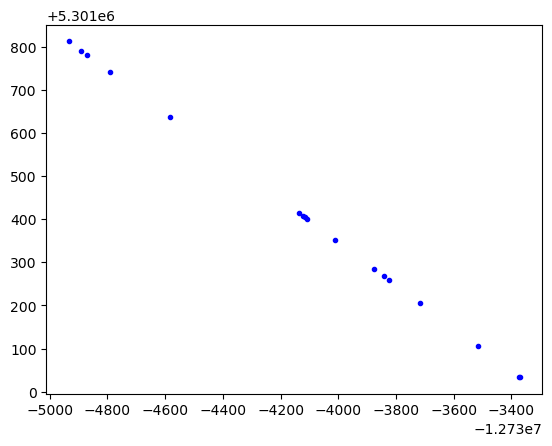

In [84]:
coords = seg6.get_coordinates()
fig, ax = plt.subplots()
plt.plot(list(coords.x),list(coords.y), '.b')

In [86]:
seg6.length

5    1746.104404
dtype: float64

We can see that the points are not evenly distributed along the line segment. Lets's try to simplify this line ssegment usign built-in tools.

In [80]:
simp6 = seg6.simplify(1, preserve_topology=False)

In [82]:
len(simp6.get_coordinates())

2

because this segment is a straight line, it can be handled with 2 points. This may not be approripate at all times and it may be better to include some interim points, eseciallyt when we want to get altitudes to calculate some gradients.

In [83]:
simp6.length

5    1746.104404
dtype: float64

Lets redistrubute points along the line more evenly.

In [88]:
new6 = simp6.segmentize(max_segment_length=200)

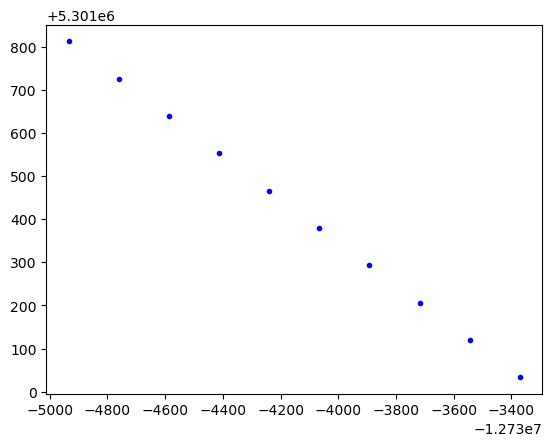

In [89]:
coords = new6.get_coordinates()
fig, ax = plt.subplots()
plt.plot(list(coords.x),list(coords.y), '.b')

In [90]:
len(new6.get_coordinates())

10

This has done a much better job of distrubuting points along the line segment. The next step is to go grab some altitudes for this data. We first need to convert the data back to lat/long (ESPG:4326)

In [91]:
new6=new6.to_crs(4326)

In [101]:
coords = new6.get_coordinates()
elev = []
for i in range(len(coords)):
    lng, lat = coords.iloc[i]
    api_url = "https://epqs.nationalmap.gov/v1/json?x=" + str(lng) + "&y=" + str(lat) + "&units=Meters&wkid=4326&includeDate=False"
    response = requests.get(api_url)
    elev.append(float(response.json()['value']))


In [102]:
elev

[1210.439575195,
 1210.874511719,
 1210.852294922,
 1210.848632813,
 1210.553466797,
 1210.453857422,
 1210.960327148,
 1210.950439453,
 1210.951538086,
 1210.955200195]

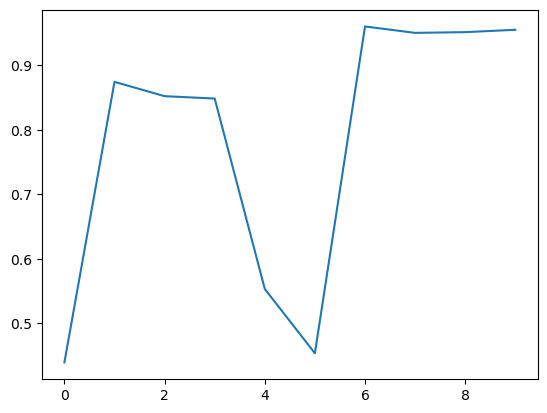

In [107]:
plt.plot(np.array(elev)-1210)

This raw data appears to be relatively noisy. We can be assured that there is a significant amount of smoothing done on the railroad bed itself.